In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import *

import warnings
warnings.filterwarnings('ignore')

## Homework Structure

This homework consists of 3 files:
* [hw3_part1](./hw3_part1.ipynb): It contains an analysis for the first part of the homework. The dataset given contains player-referee dyads and therefore each player appears more than once in the dataset. In our first approach, we keep the dataset as it is, i.e. we do not perform any <code>groupby</code> operation. We remove features that add noise to the dataset and achieve an of 77%.
* [hw3_part1_second_approach](./hw3_part1_second_approach.ipynb): It contains an analysis for the first part of the homework with a second approach on the dataset. More concretely, we do perform a <code>groupby</code> operation using the player name. Achieve a very poor accuracy.
* [hw3_part2](./hw3_part2.ipynb): It contains an analysis for the second part of the homework. More concretely, we perform a <code>groupby</code> operation on the player name and investigate if we can build to separate clusters for white and black soccer player. Our analysis shows that this clustering is not successful.

## Important Note Before Starting

This notebook file contains the same analysis as the <code>hw3_part1</code> file. However, we make an assumption described in [this](#assumption) part of the report.

We noticed that the analysis presented here does not improve the performance of the classifier. Therefore, the code is not well commented. Feel free to skip this analysis in case you already studied the <code>hw3_part1</code> file.

## Data loading

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv')
data.shape

(146028, 28)

In [3]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


From the given data description, we consider that some features do not carry any information about the skin colour of a player. These features are <code>photoID, playerShort, player, position, Alpha_3, birthday, club</code> and are dropped from the initial dataframe.

In [4]:
drop_features = ['photoID', 'player', 'position', 'Alpha_3', 'birthday', 'club']
data = data.drop(drop_features, axis=1)
data.shape

(146028, 22)

The skin colour of a player is encoded in the <code>rater1</code> and <code>rater2</code> attributes. Here, we verify that each time <code>rater1</code> has <code>NA</code>, <code>rater2</code> has also <code>NA</code>.

In [5]:
(data['rater1'].isnull() == data['rater2'].isnull()).sum() == data.shape[0]

True

We drop those rows since we do not have any output label.

In [6]:
data.dropna(axis=0,subset=['rater1','rater2'], inplace=True)

In [7]:
columns_with_nan = pd.isnull(data).sum() > 0
columns_with_nan = list(columns_with_nan[columns_with_nan].index)
print(columns_with_nan)

['height', 'weight', 'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp']


For those columns, we fill the <code>NA</code> values with the median of each column.

In [8]:
for name in columns_with_nan:
    data[name] = fill_nan_values(data[name])

Now, the dataframe does not contain any <code>NA</code> values.

In [9]:
data.isnull().values.any()

False

In order to proceed, we need to convert the <code>leagueCountry</code> into categorical variables with integer encoding.

In [10]:
data['leagueCountry'] = data['leagueCountry'].astype('category')
cat_cols = data.select_dtypes(['category']).columns
data[cat_cols] = data[cat_cols].apply(lambda col : col.cat.codes) 

<a name="assumption"></a>

## Approaching the dataset from another scope

We notice that each player appears more than ones in the dataset. Here, we group by player and aggretate using the <code>mean</code> function. We aim at seeing if this approach yield better performance. The rest of the analysis is the same, as in the first notebook of the exercise. However, we notice worse performance. The random forest classifier cannot perform better than 46% of accuracy in the test set.

In [11]:
df = data.groupby(by=['playerShort','leagueCountry'],as_index=False).mean()

In [12]:
df.head()

,playerShort,leagueCountry,height,weight,games,victories,ties,defeats,goals,yellowCards,...,rater1,rater2,refNum,refCountry,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,aaron-hughes,0,182.0,71.0,3.939759,1.487952,1.078313,1.373494,0.054217,0.114458,...,0.25,0.00,1612.656627,43.921687,0.346459,19710.156627,0.000652,0.494575,20637.277108,0.004065
1,aaron-hunt,2,183.0,73.0,3.393939,1.424242,0.737374,1.232323,0.626263,0.424242,...,0.00,0.25,1662.515152,25.070707,0.348818,26104.292929,0.000219,0.449220,26864.454545,0.000993
2,aaron-lennon,0,165.0,63.0,4.079208,1.980198,0.960396,1.138614,0.306931,0.108911,...,0.25,0.25,1598.871287,42.772277,0.345893,21234.861386,0.000367,0.491482,22238.742574,0.002032
3,aaron-ramsey,0,178.0,76.0,2.500000,1.442308,0.403846,0.653846,0.375000,0.298077,...,0.00,0.00,1668.500000,45.067308,0.346821,38285.826923,0.003334,0.514693,39719.980769,0.013522
4,abdelhamid-el-kaoutari,1,180.0,73.0,3.351351,1.108108,1.081081,1.162162,0.027027,0.216216,...,0.25,0.25,1610.891892,17.189189,0.331600,2832.351351,0.001488,0.335587,2953.837838,0.005296


In [13]:
df['playerShort'].nunique() == df.shape[0]

True

In [14]:
df['rater1'].value_counts()

0.00    626
0.25    551
0.50    170
0.75    140
1.00     98
Name: rater1, dtype: int64

In [15]:
print(data.shape)
print(df.shape)

(124621, 22)
(1585, 22)


In [16]:
X = df.drop(['playerShort','rater1','rater2'], axis=1)

Also, we need to convert the output labels from continuous values to integer numbers, that represent labels. Therefore:
* labels range in the interval[0, 4]
* the higher the value, the darker the skin colour

In [17]:
y = df['rater1'].map({0.0:0,0.25:1,0.5:2,0.75:3,1.0:4})

## Applied Machine Learning

We start by defining a **baseline model**. This model predicts always the most frequent class in our dataset.

In [18]:
y_pred = y.value_counts()

In [19]:
np.max(y_pred)
accuracy = np.max(y_pred) / float(np.sum(y_pred))
print(accuracy)

0.394952681388


A naive classifier has an accuracy of 40%.

### Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=0)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [21]:
y_pred = forest.predict(X)

In [22]:
from sklearn import metrics
metrics.accuracy_score(y,y_pred)

0.98485804416403788

We see that the default RF classifier achieves an accuracy of 98.3% in the training set.

We split the dataset into train and test set. The train and test set are going to be used to fit the model and evaluate the model respectively.

In [23]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)

In [24]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [25]:
y_pred = forest.predict(X_test)

In [26]:
metrics.accuracy_score(y_test,y_pred)

0.45268138801261831

Now, wee see that the same classifier achieved an accuracy of 66.8% in the test set.

In [27]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold as cross_validation_KFold
from sklearn.model_selection import KFold as model_selection_KFold

In [28]:
forest.feature_importances_

array([ 0.01315695,  0.05131088,  0.04474846,  0.06809752,  0.05718428,
        0.0446983 ,  0.05636851,  0.05241865,  0.06254711,  0.02973913,
        0.04192228,  0.06823766,  0.04894048,  0.06292545,  0.05044952,
        0.065409  ,  0.06693452,  0.05194721,  0.06296407])

Feature ranking:
1. feature 11 (0.068238)
2. feature 3 (0.068098)
3. feature 16 (0.066935)
4. feature 15 (0.065409)
5. feature 18 (0.062964)
6. feature 13 (0.062925)
7. feature 8 (0.062547)
8. feature 4 (0.057184)
9. feature 6 (0.056369)
10. feature 7 (0.052419)
11. feature 17 (0.051947)
12. feature 1 (0.051311)
13. feature 14 (0.050450)
14. feature 12 (0.048940)
15. feature 2 (0.044748)
16. feature 5 (0.044698)
17. feature 10 (0.041922)
18. feature 9 (0.029739)
19. feature 0 (0.013157)


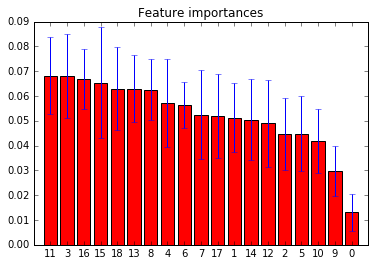

In [29]:
plot_feature_importances(X, forest)
plt.show()

We see that there is a long tail of features with low rank in terms of importance. We prune all features, starting from feature 12, till the end of the tail. We aim at running a new classifier on the reduced dataset and test if the accuracy improves.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.45268138801261831

We see that the accuracy increases to 74.3% using the dataset with the eliminated features. This indicates that we removed some of the noise contained in the dataset.

## Optimizing the RF classifier

We continue by performing CV in order to find the best values for the hyperparameters of the RF classifier, which are:
* number of trees
* depth of trees

In [31]:
scores_trees = []
num_of_trees = list(range(50,800,50))
for trees in num_of_trees:
    cv = cross_validation_KFold(X.shape[0], shuffle = True, n_folds=7, random_state=4)
    forest = RandomForestClassifier(n_estimators=trees, random_state=4, n_jobs=-1)
    print('Running 7-fold CV for ' + str(trees) + ' trees...')
    avg_test_accuracy = np.mean(cross_val_score(forest, X, y, cv=cv, scoring='accuracy'))
    scores_trees.append(avg_test_accuracy)
    print(avg_test_accuracy)

Running 7-fold CV for 50 trees...
0.426477386011
Running 7-fold CV for 100 trees...
0.444766842841
Running 7-fold CV for 150 trees...
0.449180483078
Running 7-fold CV for 200 trees...
0.442243967097
Running 7-fold CV for 250 trees...
0.447298072478
Running 7-fold CV for 300 trees...
0.451720066608
Running 7-fold CV for 350 trees...
0.453616400363
Running 7-fold CV for 400 trees...
0.452987073743
Running 7-fold CV for 450 trees...
0.454254080877
Running 7-fold CV for 500 trees...
0.448579002768
Running 7-fold CV for 550 trees...
0.451093524619
Running 7-fold CV for 600 trees...
0.452363316384
Running 7-fold CV for 650 trees...
0.449202760126
Running 7-fold CV for 700 trees...
0.451728420502
Running 7-fold CV for 750 trees...
0.451725635871


Now, we find the number of trees that gave the highest accuracy.

In [32]:
max_test_accuracy = np.max(scores_trees)
max_pos = scores_trees.index(max_test_accuracy)
opt_trees = num_of_trees[max_pos]
opt_trees

450

In [33]:
opt_trees = choose_best_model(scores_trees, num_of_trees, max_test_accuracy, 0.005)
print(opt_trees)

300


Given the optimum number of trees in the forest, we search for the best depth of trees.

In [34]:
scores_depth = []
max_depth = [10, 20, 40, 60, 80] 
for depth in max_depth:
    cv = cross_validation_KFold(X.shape[0],shuffle = True, n_folds=7,random_state=4)
    forest = RandomForestClassifier(n_estimators=opt_trees, max_depth=depth ,random_state=4,n_jobs=-1)
    print('Running 7-fold CV for ' + str(depth) + ' depth...')
    avg_test_accuracy = np.mean(cross_val_score(forest, X, y, cv=cv, scoring='accuracy'))
    scores_depth.append(avg_test_accuracy)
    print(avg_test_accuracy)

Running 7-fold CV for 10 depth...
0.454891761391
Running 7-fold CV for 20 depth...
0.451717281977
Running 7-fold CV for 40 depth...
0.451720066608
Running 7-fold CV for 60 depth...
0.451720066608
Running 7-fold CV for 80 depth...
0.451720066608


In [35]:
max_test_accuracy = np.max(scores_depth)
max_pos = scores_depth.index(max_test_accuracy)
opt_depth = max_depth[max_pos]
opt_depth

10

In [36]:
opt_depth = choose_best_model(scores_depth, max_depth, max_test_accuracy, 0.005)
print(opt_depth)

10


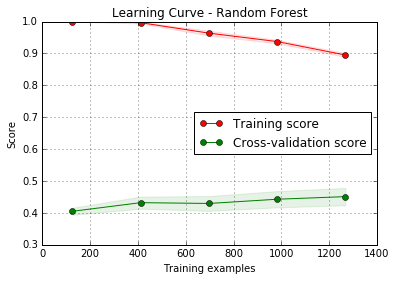

In [37]:
from sklearn.model_selection import learning_curve
forest = RandomForestClassifier(n_estimators=opt_trees, max_depth=opt_depth ,random_state=4, n_jobs=-1)
cv = cross_validation_KFold(X.shape[0],shuffle = True, n_folds=5, random_state=4)
plot_learning_curve(forest, 'Learning Curve - Random Forest', X, y, cv=cv)
plt.show()